# Example model loading and analysis
This notebook demonstrates how to load a pretrained model and perform further analysis and checks.

In [1]:
# Collect imports
from typing import Dict, Tuple, Any
from pprint import pprint
import json

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
from mlflow.tracking import MlflowClient

from components.dnf_layer import WeightedDNF

import utils.analysis
import utils.clingo

np.set_printoptions(suppress=True, precision=5, linewidth=120)

In [2]:
# Setup mlflow client
mlclient = MlflowClient(tracking_uri="http://localhost:8888") # Emptry string for local
exp_list = [x.name for x in mlclient.list_experiments()]
print(exp_list)

['relsgame-predinet-20210429-121731', 'relsgame-dnf-20210429-121731', 'gendnf-ilp-20210503-164950', 'gendnf-deep-20210428-230630', 'relsgame-recon_dnf-20210511-215943']


In [3]:
# Gather a specific run
#exp_name = exp_list[-1]
exp_name = "relsgame-recon_dnf-20210511-215943"
print("Experiment Name:", exp_name)
#all_runs = [r.info.run_id for r in mlclient.search_runs(mlclient.get_experiment_by_name(exp_name).experiment_id)]
#print(all_runs)
#run_id = all_runs[-1]
run_id = "8f7f23d93d94487fbdc5ea36c203c335"
print("Collecting artifacts for run:", run_id)
mlrun = mlclient.get_run(run_id)
pprint(mlrun.to_dictionary())
pprint(mlclient.list_artifacts(run_id))

Experiment Name: relsgame-recon_dnf-20210511-215943
{'data': {'metrics': {'epoch': 149.0,
                      'test_hexos_loss': 0.019202135503292084,
                      'test_hexos_nullary_acc': 0.9950000047683716,
                      'test_hexos_nullary_loss': 0.012011142447590828,
                      'test_hexos_recon_loss': 0.007190990261733532,
                      'test_hexos_recon_mae': 0.029814941808581352,
                      'test_pentos_loss': 0.027659451588988304,
                      'test_pentos_nullary_acc': 0.9919999837875366,
                      'test_pentos_nullary_loss': 0.026043063029646873,
                      'test_pentos_recon_loss': 0.0016163942636922002,
                      'test_pentos_recon_mae': 0.011510365642607212,
                      'test_stripes_loss': 0.15420617163181305,
                      'test_stripes_nullary_acc': 0.9909999966621399,
                      'test_stripes_nullary_loss': 0.03997662290930748,
                    

In [4]:
# Load the dataset batches for quick evaluation
npz_files = [artifact.path for artifact in mlclient.list_artifacts(run_id) if artifact.path.endswith('.npz')]
data_reports = {'_'.join(fname.split('_')[:-1]): utils.analysis.load_artifact(run_id, fname, mlclient) for fname in npz_files}
# The data format is a tuple of dictionaries
datasets = dict()
for dname, dreport in data_reports.items():
    # dname is train, test_hexos etc.
    # dreport contians reported batches and model outputs
    # such as attention maps etc.
    input_dict, output_dict = dict(), dict()
    for k, v in dreport.items():
        # in_image, out_label etc.
        if k.startswith('in'):
            input_dict[k[3:]] = v
        elif k.startswith('out'):
            output_dict[k[4:]] = v
    datasets[dname] = tf.data.Dataset.from_tensor_slices((input_dict, output_dict)).batch(v.shape[0])
# Note that for the relations game datasets, the train is a repeated datasets that loops forever
datasets.keys()

dict_keys(['test_hexos', 'test_pentos', 'test_stripes', 'train', 'validation'])

In [5]:
# Let's load the checkpointed model
models_dir = mlclient.download_artifacts(run_id, 'models')
dnf_model = tf.keras.models.load_model(models_dir + '/latest_model')
print("Number of parameters:", dnf_model.count_params())
dnf_model.compile(loss={'label': tf.keras.losses.BinaryCrossentropy(from_logits=True)}, metrics={'label': tf.keras.metrics.BinaryAccuracy('acc', threshold=0.0)})

Number of parameters: 62283


In [6]:
# Lets evaluate the model on the test hexos batch
dnf_model.evaluate(datasets['test_hexos'], verbose=1, return_dict=True)

1/1 [==============================] - 0s 417ms/step - loss: 0.0026 - nullary_loss: 0.0026 - nullary_acc: 1.0000


{'loss': 0.002586615039035678,
 'nullary_loss': 0.002586615039035678,
 'nullary_acc': 1.0}

In [7]:
# We can also ask it for the predictions, note if it is an image reconstruction model
# we will obtain {'image': (batch_size, ...), 'label': (batch_size,)}, otherwise just label
dnf_model.predict(datasets['test_hexos'], verbose=0).keys()

dict_keys(['image', 'label'])

In [8]:
# These are the all the intermediate reports, such as attention maps, features etc.
data_reports['test_hexos'].files

['in_image',
 'out_image',
 'out_label',
 'object_sel_object_scores',
 'object_sel_object_atts',
 'object_sel_objects',
 'report_layer_unary',
 'report_layer_binary',
 'report_layer_nullary',
 'facts0_nullary',
 'facts0_unary',
 'facts0_binary',
 'facts0_or_kernel',
 'facts0_conjuncts',
 'facts0_and_kernel',
 'recon_combined',
 'recon_recon_masks',
 'recon_reconstructions',
 'prediction_image',
 'prediction_label']

<AxesSubplot:ylabel='Count'>

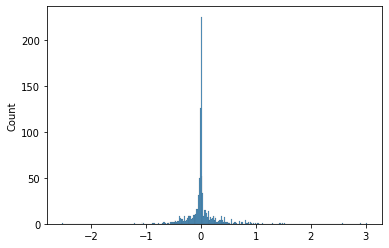

In [9]:
# Here are the weights kernel histogram
sns.histplot(data=data_reports['test_hexos']['facts0_and_kernel'].flatten())

In [10]:
# These are the reported prediction values after the training is complete
data_reports['test_hexos']['prediction_label'][:10]

array([[ 7.02416],
       [ 7.82561],
       [ 7.94817],
       [ 7.95645],
       [10.73285],
       [ 9.43431],
       [-6.17754],
       [10.20865],
       [-5.96961],
       [-6.48949]], dtype=float32)

In [11]:
# Which should be very similar to the dnf_model, note they can vary since the object selection is stochastic
dnf_model.predict(datasets['test_hexos'], verbose=0)['label'][:10]

array([[ 7.02416],
       [ 7.87824],
       [ 7.94817],
       [ 7.9571 ],
       [10.73285],
       [ 9.43431],
       [-6.17754],
       [10.20864],
       [-5.96961],
       [-6.48949]], dtype=float32)

<AxesSubplot:ylabel='Count'>

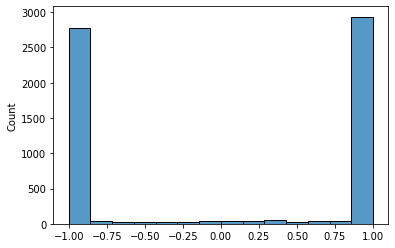

In [12]:
# These are the relations computed between the objects
sns.histplot(data=data_reports['test_hexos']['report_layer_binary'].flatten())

<AxesSubplot:ylabel='Count'>

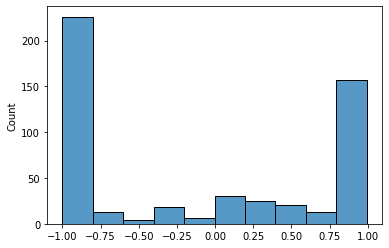

In [13]:
# These are the outputs of the conjunctive SL post existential reduction using the max operator
# the max(1) reduces the permutations
sns.histplot(data=data_reports['test_hexos']['facts0_conjuncts'].max(1).flatten())

In [14]:
# This is the actual weight used in the disjunctive SL, or_kernel
data_reports['test_hexos']['facts0_or_kernel']

array([[ 1.55504, -1.7244 ,  7.44871, -2.22057, -2.27163,  2.75774, -1.45883,  1.74555]], dtype=float32)

In [15]:
# Similarly you can find the conjunctive SL kernel here
data_reports['test_hexos']['facts0_and_kernel'].shape

(1, 8, 120)